**卷积神经网络 (Convolutional Nerual Network, CNN)**

@ Date: 2025-04-06<br>
@ Author: Rui Zhu<br>
@ Note: <br> 
    1. CNN是一类强大的、为处理图像数据而设计的神经网络<br>
    2. CNN需要的参数少于全连接架构的网络, 而且卷积容易使用GPU平行计算

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path

from astrokit import d2l

dir_data = Path("/Users/rui/Code/Astronote/32_PyTorch/data/chapter6")
dir_data.mkdir(parents=True, exist_ok=True)

---
# 基本概念
- 图像中有丰富的结构, CNN通过卷积层提取了图像的结构特征
- 图像中的结构特性:
    1. 平移不变性(Translation Invariance): 图像中的物体可以出现在任意位置, 识别物体不应关注其在图像中的具体位置
    2. 局部性(Locality): 图像中的对象识别关注的是局部区域, 而不是整个图像
- 从MLP到CNN(数学表示):
    1. 已知二维输入图像$X_{i, j}$, 则MLP第一个隐藏层(特征图)可表示为:$$H_{i, j} = U_{i, j} + \sum_k \sum_l W_{i, j}^{k, l} X_{k, l}$$
    2. 使用($k=i+a$, $l=j+b$)重新索引下标($k, l$): $$H_{i, j} = U_{i, j} + \sum_a \sum_b V_{i, j}^{a, b} X_{i+a, j+b}$$
    3. 由平移不变性, 检测对象在输入图像中的平移反映在特征图中的平移, 即$U_{i, j}$和$V_{i, j}^{a, b}$不依赖于$(i, j)$: $$H_{i, j} = u + \sum_a \sum_b V^{a, b} X_{i+a, j+b}$$
    Note:
       - 这就是卷积的数学表达, $V^{a, b}$称为卷积核, 即卷积层的权重, 是可学习的参数
       - $V^{a, b}$比$V_{i, j}^{a, b}$大幅缩减参数规模, 通过对象在图像中的平移不变性
    4. 由局部性原则, 卷积区域比图像小, 由此可以继续改写为: $$H_{i, j} = u + \sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} V^{a, b} X_{i+a, j+b}$$
    Note:
        - 其中$\Delta$是卷积核的半宽, 即5x5的卷积核, 半宽为2
- 卷积与互相关
    1. 数学中的卷积: $$(f*g)(x) = \int f(z)g(x-z)dz$$
        (对于图像离散化)$$(f*g)(i, j) = \sum_a \sum_b f(a, b)g(i-a, j-b)$$
    2. 数学中的互相关: $$(f*g)(x) = \int f(z)g(x+z)dz$$
        (对于图像离散化)$$(f*g)(i, j) = \sum_a \sum_b f(a, b)g(i+a, j+b)$$
    3. 卷积和互相关是非常类似的操作, 差别在于是否反转kernal
    4. CNN中使用的操作实际上是计算互相关
- 卷积的本质: 有效提取相邻像素间的相关特征
- 通道(channel): 对于图像, 通道表示颜色信息的维度. 对于RGB图像, 通道数为3; 灰度图像, 通道数为1

---
# 卷积层
- 严格来讲, 卷积层是错误的叫法, 实际表达的运算是互相关
- 但两者差别只在于卷积需要水平和垂直翻转二维卷积核张量
- 由于卷积核是从数据中学习得到的, 因此无论采用卷积还是互相关, 卷积层的输出不会受到影响
- 在卷积层中, 输入张量和核张量通过互相关运算, 然后添加偏置标量生成输出张量
- Feature Map: 卷积层也称特征映射
- 元素: 卷积核张量上的每一个权重称为元素
- 感受野(receptive field): 对于某一层的任意元素x, 其感受野指在向前传播期间可能影响x计算的所有元素(来自所有之前层)

## 定义互相关操作

In [2]:
def coor2d(X, K):
    """
    定义互相关运算
    """
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = torch.sum(X[i:i + h, j:j + w] * K)
    return Y

X = torch.tensor([
    [0, 1, 2], 
    [3, 4, 5], 
    [6, 7, 8]
])
K = torch.tensor([
    [0, 1],
    [2, 3]
])
Y = coor2d(X, K)
print(Y)

tensor([[19., 25.],
        [37., 43.]])


## 定义卷积层
- 卷积层的两个被训练参数: 卷积核, 标量偏置
- 高度h和宽度w的卷积核称为hxw卷积核, 带有hxw卷积核的卷积层, 称为hxw卷积层

In [3]:
class Conv2d(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        return coor2d(x, self.weight) + self.bias

## 卷积层的应用举例: 边缘检测

In [4]:
# 定义测试图像
X = torch.ones((6, 8))
X[:, 2:6] = 0
print(X)

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])


In [5]:
# 构造卷积核, 水平两个元素相同输出0, 否则非0
K = torch.tensor([[1, -1]])

In [6]:
Y = coor2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [7]:
coor2d(X.T, K)  # 这个卷积核只能检测垂直边缘, 不能检测水平边缘

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 学习卷积核
- 已知输入X和输出Y, 通过训练, 学习出这个卷积核

In [8]:
# 构造卷积层
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# 使用4维输入和输出格式(批量大小, 通道, 高度, 宽度)
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 0.03

# 训练卷积层
for i in range(20):
    Y_hat = conv2d(X)
    loss = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    loss.sum().backward()
    
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    print(f"epoch {i + 1}, loss {loss.sum():.3f}")

print(f"Final kernel: {conv2d.weight.data.reshape(1, 2)}")

epoch 1, loss 10.943
epoch 2, loss 4.647
epoch 3, loss 2.009
epoch 4, loss 0.891
epoch 5, loss 0.408
epoch 6, loss 0.195
epoch 7, loss 0.098
epoch 8, loss 0.051
epoch 9, loss 0.028
epoch 10, loss 0.016
epoch 11, loss 0.010
epoch 12, loss 0.006
epoch 13, loss 0.004
epoch 14, loss 0.002
epoch 15, loss 0.001
epoch 16, loss 0.001
epoch 17, loss 0.001
epoch 18, loss 0.000
epoch 19, loss 0.000
epoch 20, loss 0.000
Final kernel: tensor([[ 0.9986, -1.0011]])


---
# 填充和步幅
- 填充(padding): 解决卷积丢失图像边缘信息的有效方法
- 步幅(stride): 原始图像的分辨率过高, 希望大幅减少图像的高度和宽度时采用的方法
- 卷积的输出形状取决于输入形状和卷积核形状
- 假设输入形状$n_h \times n_w$, 卷积核形状$k_n \times k_w$, 则卷积后的输出形状为($n_h - k_n + 1$, $n_w - k_w + 1$)
- 很少使用不一致的步幅和填充

## 填充
- 只有使用1x1的卷积核, 卷积后的形状才与原图像形状相同
- 卷积核约大, 丢失像素越多
- 连续卷积多次后, 累积丢失的像素数就会增多
- 填充: 在输入图像的边缘填充0, 假设填充$p_h$行, $p_w$列, 则输出形状($n_h + p_h - k_n + 1$, $n_w + p_w - k_w + 1$)
- 通常使用`奇数`的卷积核大小
- 当卷积核或输入图像的形状不是正方形时, 可以填充不同的数值, 使输出形状是正方形

In [9]:
def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape)  # 这里的(1, 1)表示批量大小和通道数
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape  # 输出形状为(8, 8), 因为padding=1

torch.Size([8, 8])

In [10]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape  # 输出形状为(8, 8), 因为padding=(2, 1)

torch.Size([8, 8])

## 步幅
- 计算互相关时, 卷积窗口默认向下、向右滑动1个元素
- 为了高效计算或缩减采样次数, 卷积窗口可以跳过一些元素, 每次滑动的元素数量称为步幅

In [11]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape  # 输出形状为(4, 4), 因为stride=2

torch.Size([4, 4])

In [12]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape  # 输出形状为(3, 2), 因为stride=(3, 4)

torch.Size([2, 2])

---
# 多输入多输出通道

## 多输入通道
- 假设有$c_i$个通道, 输入图像的形状为($c_i \times n_h \times p_h$), 则需要卷积核形状($c_i \times k_h \times k_w$)
- 多输入通道的卷积操作: 每个通道的二维图像与二维卷积核做互相关运算, 然后对应位置元素求和
- 多输入通道 -> 一个输出通道

In [13]:
def corr2d_multi_in(X, K):
    """
    多输入通道互相关运算
    """
    return sum(coor2d(x, k) for x, k in zip(X, K))

In [14]:
X = torch.tensor(
    [
        [[0, 1, 2], [3, 4, 5], [6, 7, 8]], 
        [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
    ]
)
X

tensor([[[0, 1, 2],
         [3, 4, 5],
         [6, 7, 8]],

        [[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [15]:
K = torch.tensor(
    [
        [[0, 1], [2, 3]], 
        [[1, 2], [3, 4]]
    ]
)
K

tensor([[[0, 1],
         [2, 3]],

        [[1, 2],
         [3, 4]]])

In [16]:
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 多输出通道
- 多输出通道的操作: 
    假设输入通道数量$c_i$, 输出通道数量$c_o$, 则卷积核张量形状为($c_o \times c_i \times k_h \times k_w$).
    每个输出通道(共$c_o$个), 分别执行上述多输入通道的操作, 然后堆叠最终结果.
- 多输出通道的意义: 
    1. 每个输出通道的结果可以看成是对不同特征(卷积核)的响应
    2. 每个输出通道不是独立学习的, 是为了共同使用而优化的

In [17]:
def coor2d_multi_in_out(X, K):
    """
    多输入通道和多输出通道互相关运算
    """
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [18]:
# 创建多输出通道卷积核
K = torch.tensor(
    [
        [[0, 1], [2, 3]], 
        [[1, 2], [3, 4]]
    ]
)
K = torch.stack((K, K+1, K+2), dim=0)
print(K.shape)
K

torch.Size([3, 2, 2, 2])


tensor([[[[0, 1],
          [2, 3]],

         [[1, 2],
          [3, 4]]],


        [[[1, 2],
          [3, 4]],

         [[2, 3],
          [4, 5]]],


        [[[2, 3],
          [4, 5]],

         [[3, 4],
          [5, 6]]]])

In [19]:
coor2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 1 x 1卷积层
- 1 x 1卷积的唯一计算发生在通道上
- 可以将1 x 1卷积层看成每个像素位置应用的全连接层
- 1x1卷积层常用于调整网络层的通道数量和控制模型复杂度

In [20]:
# 验证1x1卷积层就是全连接层
def coor2d_multi_in_out_1x1(X, K):
    """
    全连接方法实现1x1卷积
    """
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = coor2d_multi_in_out_1x1(X, K)
Y2 = coor2d_multi_in_out(X, K)

float(torch.abs(Y1 - Y2).sum())

4.386529326438904e-07

---
# 汇聚层(Pooling Layer)
- 汇聚层也称池化层
- 汇聚层的意义:
    1. 降低卷积层对位置的敏感性
    2. 降低对空间将采样表示的敏感性
- 汇聚层的操作:
    1. 指定形状的汇聚窗口, 遍历输入的各个位置, 指定汇聚方法
    2. 通常计算汇聚窗口中所有元素的最大值或平均值, 分别称为最大汇聚和平均汇聚
- $p \times q$汇聚层: 汇聚窗口形状为$p \times q$的汇聚层, 其汇聚操作称为$p \times q$汇聚

## 最大池化和平均池化

In [21]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))  # 输出形状
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i:i + p_h, j:j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i:i + p_h, j:j + p_w].mean()
    return Y

In [22]:
X = torch.tensor([
    [0., 1, 2], 
    [3, 4, 5], 
    [6, 7, 8]
])
pool2d(X, (2, 2), mode='max')  # 最大池化

tensor([[4., 5.],
        [7., 8.]])

In [23]:
pool2d(X, (2, 2), mode='avg')  # 平均池化

tensor([[2., 3.],
        [5., 6.]])

## 汇聚层的填充和步幅
- pytorch中的汇聚层的步幅与汇聚窗口大小相同

In [24]:
# 构建输入张量, 样本数和通道数均为1
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [25]:
pool2d(X[0][0], (3, 3), mode='max')  # 最大池化

tensor([[10., 11.],
        [14., 15.]])

In [26]:
# 使用pytorch的池化层
pool2d = nn.MaxPool2d(kernel_size=3, stride=1, padding=0)
pool2d(X)

tensor([[[[10., 11.],
          [14., 15.]]]])

In [27]:
pool2d = nn.MaxPool2d(kernel_size=3)  # 默认stride=kernel_size, padding=0
pool2d(X)

tensor([[[[10.]]]])

In [28]:
pool2d = nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 多个通道
- 汇聚层在每个通道上单独运算
- 不像卷积层那样对多通道上的输出汇总, 因此, 汇聚层的输出通道数与输入通道数相同

In [29]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X = torch.cat((X, X+1), 1)
X.shape

torch.Size([1, 2, 4, 4])

In [30]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

---
# LeNet
- 最早发布的卷积神经网络之一, 由贝尔实验室Yann LeCun (杨立昆)在1989年提出, 目的是手写数字识别
- LeNet主要有7层:
    1. C1卷积层
    2. S2汇聚层
    3. C3卷积层
    4. S4汇聚层
    5. F5全连接层
    6. F6全连接层
    7. 输出层
- LeNet使用Sigmoid函数和平均汇聚, 因为ReLU和最大汇聚那时还没出现

## 搭建网络

In [31]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),   # C1
    nn.AvgPool2d(kernel_size=2, stride=2),  # S2
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),  # C3
    nn.AvgPool2d(kernel_size=2, stride=2),  # S4
    nn.Flatten(),  # 展平
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),  # F5
    nn.Linear(120, 84), nn.Sigmoid(),  # F6
    nn.Linear(84, 10)  # 输出层
)

In [32]:
# 测试网络
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


## 训练

In [33]:
# 评估函数
def evaluate_accuracy(net, data_iter, device):
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
    
    metric = d2l.Accumulator(n=2)  # 正确预测数和预测总数
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy_num(net(X), y), y.numel())
    return metric[0] / metric[1]  # 正确预测数 / 总数

In [34]:
# 训练函数
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)  # 初始化权重
    net.to(device)  # 移动到指定设备
    print(f'training on {device}')

    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()  # 交叉熵损失函数

    animator = d2l.Animator(
        xlabel='epoch', xlim=[1, num_epochs], 
        legend=['train loss', 'train acc', 'test acc']
    )

    # 开始训练
    timer = d2l.Timer()
    num_batches = len(train_iter)
    for epoch in range(num_epochs):
        # 每个epoch开始时, 创建一个空的累加器
        metric = d2l.Accumulator(n=3)  # 训练损失, 正确预测数, 预测总数
        net.train()  # 设置为训练模式
        for i, (X, y) in enumerate(train_iter):
            timer.start()  # 开始计时
            optimizer.zero_grad()  # 清空梯度
            X, y = X.to(device), y.to(device)  # 移动到指定设备
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()  # 更新参数
            with torch.no_grad():  # 暂时不计算梯度
                metric.add(
                    l * X.shape[0], # 当前批次的总损失
                    d2l.accuracy_num(y_hat, y), # 准确正确数
                    X.shape[0] # 预测总数
                )
            timer.stop()

            # 更新图形
            train_loss = metric[0] / metric[2]  # 平均损失
            train_acc = metric[1] / metric[2]  # 准确率
            if (i+1) % (num_batches // 5) == 0 or i == (num_batches - 1):
                animator.add(
                    x=epoch + (i + 1) / num_batches,
                    y=[train_loss, train_acc, None]
                )
        test_acc = evaluate_accuracy(net, test_iter, device)
        animator.add(epoch + 1, [None, None, test_acc])

    print(f"train loss: {train_loss:.3f}, "
          f"train acc: {train_acc:.3f}, "
          f"test acc: {test_acc:.3f}")
    print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec on "
          f"{str(device)}")

train loss: 0.463, train acc: 0.825, test acc: 0.813
31129.2 examples/sec on mps


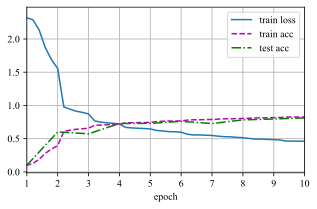

In [35]:
# 加载数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(
    batch_size=batch_size, dir_data=dir_data, resize=None
)

lr, num_epochs = 0.9, 10
train_ch6(
    net, train_iter, test_iter, num_epochs, lr, torch.device('mps')
)

train loss: 0.462, train acc: 0.828, test acc: 0.828
7147.8 examples/sec on cpu


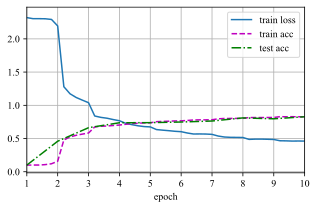

In [36]:
# 加载数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(
    batch_size=batch_size, dir_data=dir_data, resize=None
)

lr, num_epochs = 0.9, 10
train_ch6(
    net, train_iter, test_iter, num_epochs, lr, torch.device('cpu')
)